# Generative Adversarial Networks

![GAN](notebook_images/gan.jpg) 

## References:

- Generative Adversarial NetworksGenerative Adversarial Networks, Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, Yoshua BengioIan J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, Yoshua Bengio, https://arxiv.org/abs/1406.2661
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial NetworksUnsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks, Alec Radford, Luke Metz, Soumith ChintalaAlec Radford, Luke Metz, Soumith Chintala, https://arxiv.org/abs/1511.06434

- Ahlad Kumar, Deep Learning 27 - 37: GAN and WGAN, https://www.youtube.com/watch?v=RRTuumxm3CE

Most code from https://www.tensorflow.org/tutorials/generative/dcgan

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense, Reshape
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from IPython import display

import numpy as np

import os
import time

In [2]:
def show_batch(image_batch):
    columns = 8
    rows = len(image_batch) / columns + 1  
    plt.figure(figsize=(16, 2 * rows))
    for n in range(len(image_batch)):
        ax = plt.subplot(int(rows), columns, n+1)
        plt.imshow((image_batch[n]), cmap='gray')
        plt.axis('off')
        
        
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8,8))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 255.0, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()        

In [3]:
BUFFER_SIZE = 60000
BATCH_SIZE = 64

LATENT_DIM = 256

## Load and prepare data

In [4]:
# load dataset
(train_X, _), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


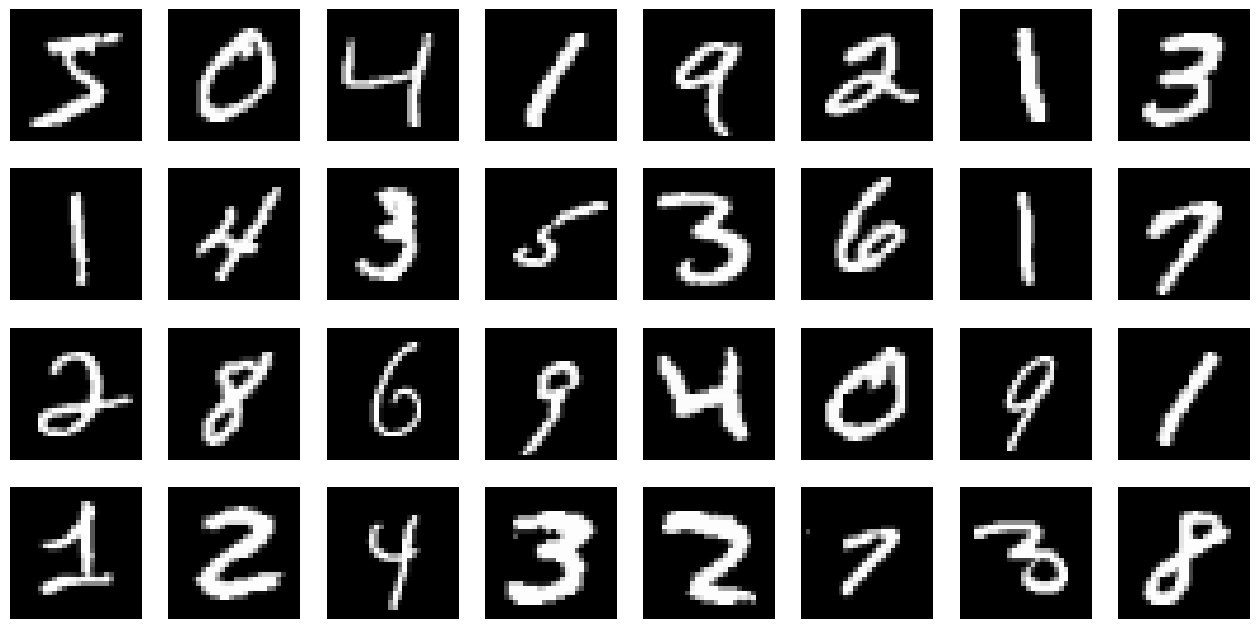

In [5]:
image_batch = train_X[:32]       
show_batch(image_batch)

# Process Data

data is reshaped from [X, 28,28] to [X, 28, 28, 1] and divided by 255 to normalize pixel values in the range [0,1]

In [6]:
# reshape and normalize
train_X = train_X.reshape(train_X.shape[0], 28, 28, 1).astype('float32') / 255.0

# convert to tensors
train_dataset = tf.data.Dataset.from_tensor_slices(train_X).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Discriminator

In [7]:
disc_inputs = Input(shape=(28,28,1))

discriminator = Conv2D(32, (5,5), strides=2, padding='same', input_shape= [28,28,1])(disc_inputs)
discriminator = LeakyReLU(alpha=0.2)(discriminator)

discriminator = Conv2D(64, (5,5), strides=2, padding='same', input_shape= [28,28,1])(discriminator)
discriminator = LeakyReLU(alpha=0.2)(discriminator)
discriminator = BatchNormalization()(discriminator)

discriminator = Flatten()(discriminator)
discriminator = Dense(1, activation='sigmoid')(discriminator)

discriminator = Model(disc_inputs, discriminator)
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        832       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 64)         256       
 ormalization)                                                   
                                                             

In [8]:
# nas GANs as redes não têm que ser simétricas
generator = tf.keras.Sequential()

generator.add(Dense(512, input_shape=(LATENT_DIM,)))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())

generator.add(Dense(7*7*64)) #de modo a poder transformar numa convolução
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())

generator.add(Reshape((7,7,64)))

generator.add(Conv2DTranspose(32, (3,3), strides=2, padding='same'))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(64, (3,3), strides=2, padding='same')) #temos 64 canais numa image 28 por 28
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(1, (3,3), strides=1, padding='same', activation='sigmoid'))

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 3136)              1608768   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 3136)              0         
                                                                 
 batch_normalization_2 (Batc  (None, 3136)             12544     
 hNormalization)                                        

1/1 [==============================] - 11s 11s/step


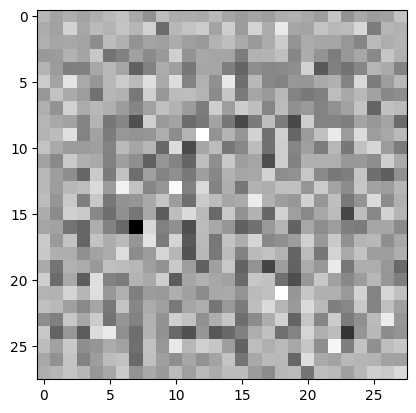

In [9]:
noise = tf.random.normal([1, LATENT_DIM])
generated_image = generator.predict(noise)
plt.imshow(generated_image[0,:,:,0], cmap='gray')

In [11]:
fake_pred = discriminator(generated_image)
print('F ', fake_pred.numpy()[0])

real_pred = discriminator(train_X[:1])
print('R ', real_pred.numpy()[0])

F  [0.50210893]
R  [0.49901506]


In [12]:
gen_opt = Adam(2e-4, beta_1=0.3)
disc_opt = Adam(2e-4, beta_1=0.3)

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [17]:
def generator_loss(fake_output):
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return fake_loss

In [18]:
num_examples = 16

noise_test = tf.random.normal([num_examples, LATENT_DIM])

@tf.function
def train_step(images):
    
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        generated_images = generator(noise, training = True)
        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)
        
        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)
        
    gen_grad = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grad = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gen_opt.apply_gradients(zip(gen_grad, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

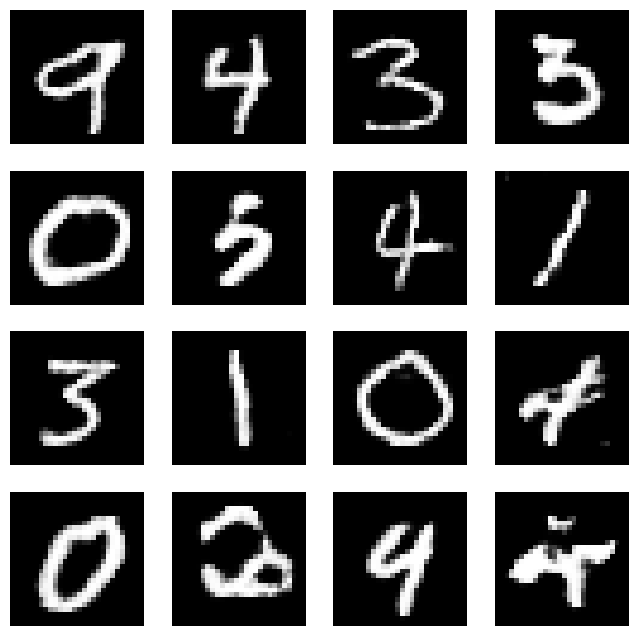

In [19]:
def train(dataset, epochs):
    
    for epoch in range(epochs):
        
        for image_batch in dataset:
            
            gen_loss, disc_loss = train_step(image_batch)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch, noise_test)
        
train(train_dataset, 25)